# Import the necessary libraries

In [4]:
import warnings
warnings.filterwarnings("default", category=DeprecationWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import keras
import pydot as pyd
keras.utils.vis_utils.pydot = pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# Load the data into Pandas dataframe

In [5]:
df = pd.read_csv('data/spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# Understanding data distribution better

Text(0.5, 1.0, 'Number of ham and spam messages')

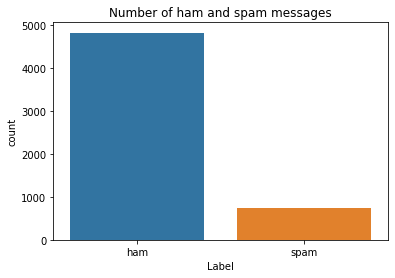

In [7]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

## Create input and output vectors.
### Process the labels.

In [8]:
X = df.v2
Y = df.v1
le = LabelEncoder() # sklearn preprocessing object LabelEncoder to encode label
Y = le.fit_transform(Y) # fit and transform Y into encode label
Y = Y.reshape(-1,1)  # reshape value encode into -1(spam), 1(ham)

# Split into training and test data.

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [10]:
X_train

5082    Amazing : If you rearrange these letters it gi...
4644                    Are you planning to come chennai?
3514                     I'm job profile seems like bpo..
2925                      Im done. Just studyn in library
4509    This weekend is fine (an excuse not to do too ...
                              ...                        
1220    No. 1 Nokia Tone 4 ur mob every week! Just txt...
2984    No break time one... How... I come out n get m...
1030    Can not use foreign stamps in this country. Go...
2073    FreeMsg: Claim ur 250 SMS messages-Text OK to ...
4628    Only saturday and sunday holiday so its very d...
Name: v2, Length: 4736, dtype: object

# Process the data
- Tokenize the data and convert the `text` to `sequences`.
- Add padding `to ensure` `that all the sequences` `have the same shape`.
- There are many ways of taking the `max_len` `and here` `an arbitrary` `length of 150` `is chosen`.

In [11]:
max_words = 1000 # arbitrary set max words for corpus
max_len = 150 # maximum len for max shape array

In [12]:
tok = Tokenizer(num_words=max_words) # keras.preprocessing.text 
# Tokenizer object

tok.fit_on_texts(X_train) # Updates internal vocabulary based on a list 
# of texts

sequences = tok.texts_to_sequences(X_train) # Transforms each text in 
# texts to a sequence of integers

sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) 
# keras.preprocessing sequence method to transforms a list of sequences 
# (lists of integers) into a 2D Numpy array of shape `(num_samples, 
# num_timesteps)`. `num_timesteps` is either the `maxlen` argument 
# if provided, or the length of the longest sequence otherwise

In [13]:
for i,k in enumerate(tok.index_word.items()):  # 1000 words
    print(k)
    if i == 5:
        break

(1, 'i')
(2, 'to')
(3, 'you')
(4, 'a')
(5, 'the')
(6, 'u')


In [14]:
for i,k in enumerate(sequences): # sequence of integers mapping words to tok corpus
    print(k)
    if i == 5:
        break

[35, 3, 521, 15, 5, 276, 341, 5, 111, 84, 652, 8, 482, 386, 482, 77, 62]
[21, 3, 2, 59, 693]
[34, 277, 60]
[159, 294, 37, 8]
[40, 412, 9, 257, 121, 24, 2, 28, 139, 116]
[1, 61, 82, 15, 550, 3]


In [15]:
sequences_matrix

array([[  0,   0,   0, ..., 482,  77,  62],
       [  0,   0,   0, ...,   2,  59, 693],
       [  0,   0,   0, ...,  34, 277,  60],
       ...,
       [  0,   0,   0, ...,   8,  40,  55],
       [  0,   0,   0, ..., 268,  27,  91],
       [  0,   0,   0, ...,  62, 166, 849]], dtype=int32)

In [16]:
sequences_matrix.shape # matrix 4736 x 150 
# (after padding sequences 150 equally)

(4736, 150)

In [17]:
# RNN
# Define the RNN structure.

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer) # (64*256)+256 = 16640 params
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer) # (256*1)+1 = 257 params
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [18]:
# Call the function and compile the model.

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

# Visualize Model

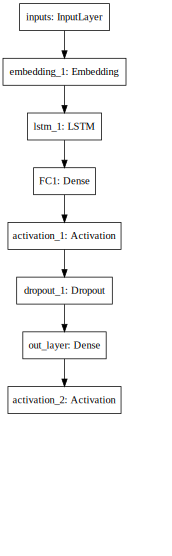

In [19]:
def visualize_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))

visualize_model(model)

# plot_model(model, to_file='model.png') # save image

In [20]:
# model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
#           validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',
#                                                         min_delta=0.0001)])
model.load_weights('weights.h5')

In [21]:
# Process the test set data.
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,
                                               maxlen=max_len)

In [22]:
# Evaluate the model on the test set.

accr = model.evaluate(test_sequences_matrix,Y_test)


836/836 [==============================] - 3s 3ms/step


In [23]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.753
  Accuracy: 0.862


In [24]:
# model.save_weights('weights.h5')